## Lab 02

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

Get Helper Plot

In [2]:
import urllib, os, pathlib

if not os.path.exists("Helplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Hut/refs/heads/main/Helplot.py"

  urllib.request.urlretrieve(giturl, "Helplot.py")

In [3]:
if not os.path.exists("Confuplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Hart/refs/heads/main/Confuplot.py"

  urllib.request.urlretrieve(giturl, "Confuplot.py")

We'll Use TensorFlow Datasets on Cats v Dogs Cases

Our Dataset will be Train, Test, Validation

In [ ]:
datafile = "cats_vs_dogs"

split = ["train[:10%]", "train[80%:90%]", "train[90%:]"]

ontrue = True

(train, test, valid), info = tfds.load(datafile, split=split, as_supervised=ontrue, with_info=ontrue)

In [5]:
labeler = info.features["label"].names

labeler = [i.capitalize() for i in labeler]

labeler

['Cat', 'Dog']

In [6]:
len(train), len(test), len(valid)

(2326, 2326, 2326)

### Feature Engineer

Perform Reshaping, Shuffle, Batching on Our Dataset

In [7]:
input_shape = (160, 160)

inlabel = lambda i, l : (tf.image.resize(i, input_shape) / 255.0, l)

batch = 64

# Resize, Shuffle, Batching

train = train.map(inlabel).shuffle(len(train)).batch(batch).cache()

test = test.map(inlabel).batch(batch)

valid = valid.map(inlabel).batch(batch)

### Model Spirior

Fine Tune Mobilenet Base Model to Perform Binary Classification on Cats v Dogs Dataset

In [ ]:
from tensorflow.keras.applications import MobileNet

import tensorflow.keras.layers as layers

inputs = layers.Input((160, 160, 3))

intnet = MobileNet(input_tensor=inputs, weights='imagenet', include_top=False)

intnet.trainable = False

In [9]:
x = layers.GlobalAveragePooling2D()(intnet.output)

output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, output)

In [10]:
model.input

<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, name=keras_tensor>

In [11]:
model.output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_87>

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

plot = model.fit(train, validation_data=valid, epochs=5)

### Model Test

Testing Model on Train, Test and Validation

In [13]:
model.evaluate(train, verbose=False)

[0.06912597268819809, 0.9776440262794495]

In [14]:
model.evaluate(test, verbose=False)

[0.09056378901004791, 0.9643164277076721]

In [15]:
model.evaluate(valid, verbose=False)

[0.07698754966259003, 0.9729148745536804]

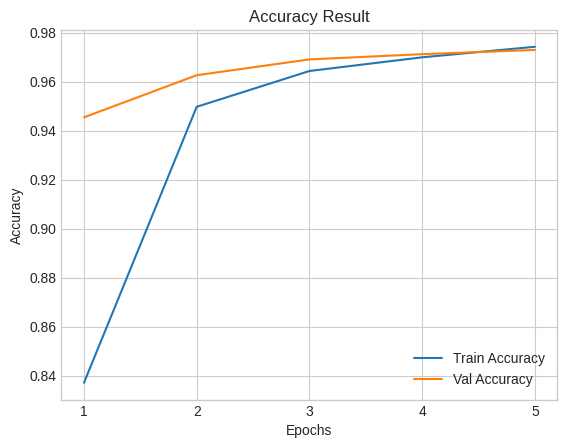

In [16]:
from Helplot import Helplot

rel = Helplot(plot)

rel.Relplot

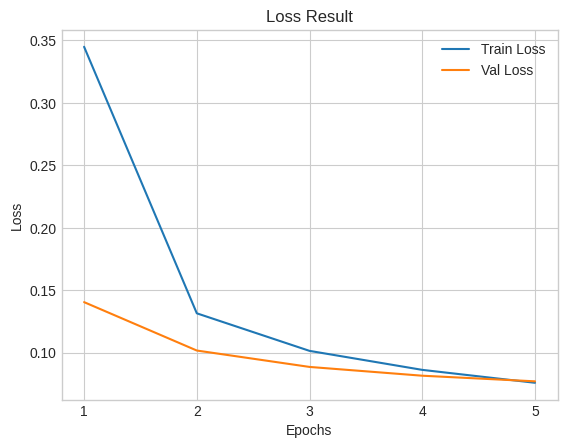

In [17]:
rel.Falplot

### TensorFlow Lite

Deploy Model on TensorFlow Lite & Test TensorFlow Lite Model

In [ ]:
ModelFolder = "/content/Modelite"

model.export(ModelFolder)

In [19]:
tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(ModelFolder)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

In [20]:
tflite_model = tflite_model.convert()

pathfile = "HartModel02.tflite"

tflite_model_file = pathlib.Path(pathfile)

tflite_model_file.write_bytes(tflite_model)

3382312

In [21]:
os.path.getsize(pathfile) / float(2**20)

3.2256240844726562

In [22]:
interpreter = tf.lite.Interpreter(model_path=pathfile)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor'], 'outputs': ['output_0']}}

In [23]:
lite_interpreter = interpreter.get_signature_runner('serving_default')

lite_interpreter

In [24]:
test_images = next(iter(test))

test_images[0].shape

TensorShape([64, 160, 160, 3])

In [25]:
testa = lite_interpreter(keras_tensor=test_images[0])['output_0']

testa = tf.round(testa)

logits = tf.reshape(testa, (64, )).numpy()

logits

array([1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)

In [26]:
label = test_images[1].numpy()

label

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0])

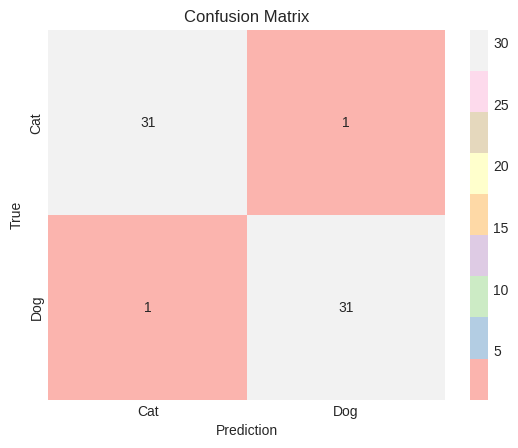

In [27]:
from Confuplot import Confuplot

Confuplot(label=label, logits=logits, labeler=labeler, cmap="Pastel1", fmt="g")

### TensorFlow Serving

Deploy Model to TensorFlow Serving & Perform Modification on Last Layer

Modification is Perform to Auto Label our Binary Classification Output

In [28]:
# Create Outlabel Layer to Use in TensorFlow Serving

class Outlabel(tf.keras.layers.Layer):
  def __init__(self):
    super(Outlabel, self).__init__()
    self.label = labeler

  def call(self, inputs):
    tf.config.run_functions_eagerly(True)
    logits = tf.cast(tf.round(inputs), tf.int32)
    logits = tf.gather(self.label, logits)
    return logits

In [29]:
# Modular Model to TensorFlow Serving

input_layer = model.input

modular = model(input_layer)

output_layer = Outlabel()(modular)

modular_server = tf.keras.Model(input_layer, output_layer)

modular_server.output

<KerasTensor shape=(None, 1), dtype=string, sparse=False, name=keras_tensor_89>

In [30]:
modular_server.input

<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, name=keras_tensor>

In [31]:
model.input

<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, name=keras_tensor>

In [32]:
import warnings

warnings.filterwarnings("ignore")

tester = modular_server.predict(test_images[0], verbose=False)

tester[:3]

array([[b'Dog'],
       [b'Cat'],
       [b'Dog']], dtype=object)

In [ ]:
ModelFolder = "/content/ModelServer"

ModelSerial = "1"

ModuleFolder = os.path.join(ModelFolder, ModelSerial)

modular_server.export(ModuleFolder)

In [34]:
os.environ["ModelFolder"] = ModelFolder

In [ ]:
!apt update

!apt-get install tensorflow-model-server

In [36]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=inter_model \
  --model_base_path="${ModelFolder}" > server.log 2>&1

In [37]:
!tail server.log

In [38]:
import json, requests

test_img, test_label = next(iter(valid))

test_img = test_img.numpy().tolist()

url = "http://127.0.0.1:8501/v1/models/inter_model:predict"

In [39]:
image = json.dumps({"signature_name":"serving_default", "instances":test_img})

content = {"content-type":"application/json"}

response = requests.post(url, data=image, headers=content)

loader = json.loads(response.text)

result = loader["predictions"]

result[:5]

[['Cat'], ['Dog'], ['Dog'], ['Cat'], ['Cat']]